In [1]:
from __future__ import print_function
import os
import cv2
import h5py
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/home/tony/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.patches as patches

In [38]:
dataset_type     = 'test' # Change to train/test
dataset_dir      = './dataset'
curated_dataset  = os.path.join(dataset_dir, dataset_type + '_cropped')
curated_textfile = os.path.join(dataset_dir, dataset_type + '.txt')
ground_attn_dir  = os.path.join(dataset_dir, dataset_type + '_attn_grnd')
file_path        = './dataset/%s/' % (dataset_type)
img_size         = (64, 64) # (width, height)
max_steps        = 5
ground_attention_downsample = (7, 7)

### Functions

In [39]:
def load_file(curated_textfile):
    all_data = []

    with open(curated_textfile, 'r') as f:
        frames = f.readlines()

    for frame in frames:
        frame = frame.split(', ')
        iterm_data = []

        # Remove all non-interger characters
        for i in frame:
            i = i.replace("[", "")
            i = i.replace("[[", "")
            i = i.replace("]", "")
            i = i.replace("]]", "")
            i = i.replace("'", "")

            iterm_data.append(int(i))

        final_data = []

        count = 0
        for u in range(max_steps):
            each_data = []
            for k in range(6):
                if k == 0:
                    each_data.append(str(iterm_data[count]) + '.png')
                else:
                    each_data.append(iterm_data[count])

                count += 1

            final_data.append(each_data)

        all_data.append(final_data)

    return all_data

In [42]:
# Load data
all_data = load_file(curated_textfile)
print('Data loaded!')

Data loaded!


In [43]:
def gaussian2d1(sup, scales):
    """
    Creates a 2D Gaussian based on the size and scale.
    """
    var   = scales * scales
    shape = (sup[0], sup[1])
    n,m   = [(i-1)/2 for i in shape]
    y,x   = np.ogrid[-m:m+1,-n:n+1]
    
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var))

    return g

In [44]:
x, y = np.meshgrid(np.linspace(-1,1,64), np.linspace(-1,1,64))

In [45]:
print(x.shape)
print(y.shape)

(64, 64)
(64, 64)


In [60]:
d = np.sqrt(x*x+y*y)
sigma, mu = 1.0, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )

In [75]:
np.max(g)

0.9997480791044941

In [61]:
g.shape

(64, 64)

In [71]:
g_norm = (g - np.min(g))/(np.max(g) - np.min(g))

In [72]:
g_norm

array([[0.        , 0.01847656, 0.0369152 , ..., 0.0369152 , 0.01847656,
        0.        ],
       [0.01847656, 0.03753948, 0.05656328, ..., 0.05656328, 0.03753948,
        0.01847656],
       [0.0369152 , 0.05656328, 0.07617103, ..., 0.07617103, 0.05656328,
        0.0369152 ],
       ...,
       [0.0369152 , 0.05656328, 0.07617103, ..., 0.07617103, 0.05656328,
        0.0369152 ],
       [0.01847656, 0.03753948, 0.05656328, ..., 0.05656328, 0.03753948,
        0.01847656],
       [0.        , 0.01847656, 0.0369152 , ..., 0.0369152 , 0.01847656,
        0.        ]])

In [76]:
w = np.argmax(g_norm)
w1 = g_norm.flatten()[w]
print(w1)

1.0


In [77]:
np.sum(g_norm)

2317.3338742886617

In [78]:
r = g_norm.flatten()/np.sum(g_norm)

In [79]:
r

array([0.00000000e+00, 7.97319706e-06, 1.59300325e-05, ...,
       1.59300325e-05, 7.97319706e-06, 0.00000000e+00])

In [80]:
w = np.argmax(r)
w1 = r[w]
print(w1)

0.000431530394085731


In [70]:
r[2015]

0.0003364926112272561

In [29]:
g_norm = (g - np.min(g))/(np.max(g) - np.min(g))

In [50]:
g_norm

array([0.        , 0.01847656, 0.0369152 , ..., 0.0369152 , 0.01847656,
       0.        ])

In [35]:
g_norm = g_norm.flatten()

In [36]:
np.argmax(g_norm)

2015

In [37]:
g_norm[2015]

1.0

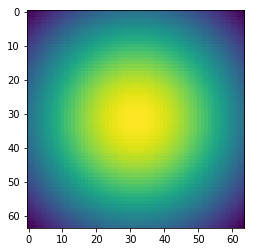

In [15]:
plt.imshow(g)

In [32]:
def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    """
    e_x = np.exp(x - np.max(x))

    return e_x / e_x.sum(axis=0)

In [33]:
def generate_ground_gaussian_attention_mask(sample, sample_top, sample_height, sample_left, sample_width):
    """
    Creates a ground truth attention mask based on ground truth bounding boxes,
    and scales to fit into the box.
    """
    sample_image_height, sample_image_width, _ = sample.shape 
    scales = np.sqrt(2) * 15 # Play with the standard deviation
    
    # Convert even to odd by adding extra px
    if sample_width%2 == 0:
        sample_width += 1
    
    if sample_height%2 == 0:
        sample_height += 1
    
    gaussain = gaussian2d((sample_width, sample_height), scales)
    # Normalize between zero and 1
    gaussain_normalized = (gaussain - np.min(gaussain))/\
                          (np.max(gaussain) - np.min(gaussain))

    sample_attention = np.zeros((sample_image_height, sample_image_width)) * 0.0
    sample_attention[sample_top:sample_top+sample_height, sample_left:sample_left+sample_width] = gaussain_normalized
        
    sample_attention_res  = cv2.resize(sample_attention, ground_attention_downsample, interpolation=cv2.INTER_NEAREST)
    
    # Convert to pro
    #sample_attention_res_norm  = sample_attention_res.flatten()

    #sample_attention_res_norm = softmax(sample_attention_res)
    #sample_attention_res_norm = np.reshape(sample_attention_res_norm, ground_attention_downsample)

    return sample_attention, sample_attention_res

In [34]:
def biggest_box(samples, total_samples):
    """
    Compute the box encompassing all the digits.
    """
    all_left  = []
    all_top   = []
    all_width = []
    all_heigt = []

    for k in range(total_samples):
        sample_label = samples[k][1]
        sample_left  = samples[k][2]
        sample_top   = samples[k][3]
        sample_width = samples[k][4]
        sample_heigt = samples[k][5]

        all_left.append(sample_left)
        all_top.append(sample_top)
        all_width.append(sample_left+sample_width)
        all_heigt.append(sample_top+sample_heigt)

    low_left = min(all_left)
    low_top  = min(all_top)
    highest_width = max(all_width) - low_left
    highest_height = max(all_heigt) - low_top

    return low_left, low_top, highest_width, highest_height

In [145]:
def generate_stop_attention_mask(samples, sample_image, total_samples):
    """
    Create an attention mask for the stop state, which is a
    uniform mask around the digits.
    """
    sample_image_height, sample_image_width, _ = sample_image.shape

    low_left, low_top, highest_width, highest_height = biggest_box(samples, total_samples)

    x = np.ones((sample_image_height, sample_image_width))

    mask = np.ones((sample_image_height, sample_image_width))
    mask[low_top:low_top+highest_height, low_left:low_left+highest_width] = 0

    x2 = np.multiply(x, mask)

    # Downsample and re-normalize between 0 and 1
    x3_1 = cv2.resize(x2, ground_attention_downsample, interpolation=cv2.INTER_NEAREST)
    x3_1 = np.float32(x3_1.flatten())
    x3_1 = x3_1/np.sum(x3_1) + 1e-5 # For numerical stability

    return x2, x3_1

### Main

In [62]:
#------------------------------------------------------------------------------
dataset_type     = 'test' # Change to train/test
dataset_dir      = './dataset'
curated_dataset  = os.path.join(dataset_dir, dataset_type + '_cropped')
curated_textfile = os.path.join(dataset_dir, dataset_type + '.txt')
file_path        = './dataset/%s/' % (dataset_type)
img_size         = (64, 64) # (width, height)
max_steps        = 5
ground_attention_downsample = (7, 7)

In [63]:
all_data = []

with open(curated_textfile, 'r') as f:
    frames = f.readlines()

for frame in frames:
    frame = frame.split(', ')
    iterm_data = []

    # Remove all non-interger characters
    for i in frame:
        i = i.replace("[", "")
        i = i.replace("[[", "")
        i = i.replace("]", "")
        i = i.replace("]]", "")
        i = i.replace("'", "")

        iterm_data.append(int(i))

    final_data = []

    count = 0
    for u in range(max_steps):
        each_data = []
        for k in range(6):
            if k == 0:
                each_data.append(str(iterm_data[count]) + '.png')
            else:
                each_data.append(iterm_data[count])

            count += 1

        final_data.append(each_data)
    
    all_data.append(final_data)

In [64]:
all_data[0]

[['1.png', 5, 13, 3, 22, 45],
 ['1.png', 0, 0, 0, 0, 0],
 ['1.png', 0, 0, 0, 0, 0],
 ['1.png', 0, 0, 0, 0, 0],
 ['1.png', 0, 0, 0, 0, 0]]

In [65]:
all_data[0][0][0]

'1.png'

### Visualize

In [66]:
## -- debug
# check how many samples:

In [67]:
sample_index = 501

In [68]:
sample_image_path = curated_dataset + '/' + all_data[sample_index][0][0]
print('Path:', sample_image_path)

Path: ./dataset/test_cropped/502.png


In [69]:
sample_image = cv2.imread(sample_image_path)

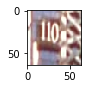

In [70]:
plt.figure(figsize=(1,1))
plt.imshow(sample_image)
plt.show()

In [71]:
sample_heigt_org, sample_width_org, _ = sample_image.shape

In [72]:
all_data[sample_index][0]

['502.png', 1, 14, 9, 7, 26]

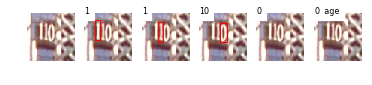

In [73]:
fig,ax = plt.subplots(1, max_steps+1)
plt.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax[0].imshow(sample_image)
ax[0].axis('off')
        
for k in range(max_steps):
    sample_left  = abs(int(all_data[sample_index][k][2]))
    sample_top   = abs(int(all_data[sample_index][k][3]))
    sample_width = abs(int(all_data[sample_index][k][4]))
    sample_heigt = abs(int(all_data[sample_index][k][5]))
    sample_label = all_data[sample_index][k][1]
    
    rect = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,\
                             linewidth=1, edgecolor='r', facecolor='none')  
    ax[k+1].text(0, 1, sample_label, color='black', backgroundcolor='white', fontsize=8)
    ax[k+1].imshow(sample_image)
    ax[k+1].add_patch(rect)
    ax[k+1].axis('off')

### Generate attention mask

In [81]:
def samples_total(samples):
    total_samples= 0
    for k in range(max_steps):
        sample_label = samples[k][1]
        
        if int(sample_label) != 0:
            total_samples += 1
        
    return total_samples

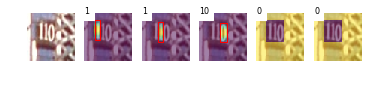

In [146]:
fig,ax = plt.subplots(1, max_steps+1)
#plt.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax[0].imshow(sample_image)
ax[0].axis('off')
        
for k in range(max_steps):
    sample_left  = abs(int(all_data[sample_index][k][2]))
    sample_top   = abs(int(all_data[sample_index][k][3]))
    sample_width = abs(int(all_data[sample_index][k][4]))
    sample_heigt = abs(int(all_data[sample_index][k][5]))
    sample_label = all_data[sample_index][k][1]
    total_samples = samples_total(samples=all_data[sample_index])
    if int(sample_label) == 0:
        stop_mask, attn = generate_stop_attention_mask(all_data[sample_index], sample_image, total_samples)
        ax[k+1].text(0, 1, sample_label, color='black', backgroundcolor='white', fontsize=8)
        ax[k+1].imshow(sample_image)        
        ax[k+1].imshow(stop_mask, alpha=0.5)
        ax[k+1].axis('off')
    else:
        acc, get_attention_mask = generate_ground_gaussian_attention_mask(sample_image,\
                                        sample_top, sample_heigt, sample_left, sample_width)
        rect = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,\
                                  linewidth=1, edgecolor='r', facecolor='none')  
        ax[k+1].text(0, 1, sample_label, color='black', backgroundcolor='white', fontsize=8)
        ax[k+1].imshow(sample_image)
        ax[k+1].imshow(acc, alpha=0.5)
        ax[k+1].add_patch(rect)
        ax[k+1].axis('off')

In [83]:
all_data[sample_index][k][0][:-4]

'502'

In [87]:
np.sum(attn.flatten())

0.010863182618907808

In [159]:
attn[18]

1e-05

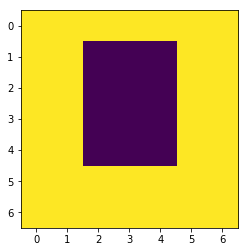

In [150]:
plt.imshow(np.reshape(attn, (7,7)))

In [117]:
#a = softmax(get_attention_mask.flatten())

In [121]:
get_attention_mask = np.float32(get_attention_mask.flatten())

In [122]:
get_attention_mask.dtype

dtype('float32')

In [123]:
get_attention_mask

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.5422475 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.89929444, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.34916565, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

In [124]:
get_attention_mask/np.sum(get_attention_mask)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.30281186, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.5022006 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.19498754, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

In [134]:
r = np.reshape((get_attention_mask/np.sum(get_attention_mask) + 1e-6), (1, 49))

In [135]:
r.shape

(1, 49)

In [136]:
np.sum(r)

1.000049

In [137]:
import tensorflow as tf
import numpy as np

In [138]:
sess = tf.Session()

In [139]:
a = tf.placeholder(tf.float32, shape=(None, 49))
X = tf.distributions.Categorical(probs=a)

In [140]:
a = sess.run(X.probs, feed_dict={a:r})

In [141]:
a

array([[1.0000000e-06, 1.0000000e-06, 1.0000000e-06, 1.0000000e-06,
        1.0000000e-06, 1.0000000e-06, 1.0000000e-06, 1.0000000e-06,
        1.0000000e-06, 1.0000000e-06, 1.0000000e-06, 1.0000000e-06,
        1.0000000e-06, 1.0000000e-06, 1.0000000e-06, 1.0000000e-06,
        1.0000000e-06, 1.0000000e-06, 3.0281287e-01, 1.0000000e-06,
        1.0000000e-06, 1.0000000e-06, 1.0000000e-06, 1.0000000e-06,
        1.0000000e-06, 5.0220162e-01, 1.0000000e-06, 1.0000000e-06,
        1.0000000e-06, 1.0000000e-06, 1.0000000e-06, 1.0000000e-06,
        1.9498853e-01, 1.0000000e-06, 1.0000000e-06, 1.0000000e-06,
        1.0000000e-06, 1.0000000e-06, 1.0000000e-06, 1.0000000e-06,
        1.0000000e-06, 1.0000000e-06, 1.0000000e-06, 1.0000000e-06,
        1.0000000e-06, 1.0000000e-06, 1.0000000e-06, 1.0000000e-06,
        1.0000000e-06]], dtype=float32)

In [142]:
np.sum(a)

1.000049

In [10]:
def kl(x, y):
    X = tf.distributions.Categorical(probs=x)
    Y = tf.distributions.Categorical(probs=y)
    
    return tf.distributions.kl_divergence(X, Y)

In [11]:
a = np.array([[0.25, 0.1, 0.65], [0.8, 0.15, 0.05]])
b = np.array([[0.7, 0.2, 0.1], [0.15, 0.8, 0.05]])
sess = tf.Session()
print(kl(a, b).eval(session=sess))  # [0.88995184 1.08808468]

[0.88995184 1.08808468]
